# Assignment 6: Attention (please!)

---

## Task 2) Sentiment Analysis

In this task, we'll use the kaggle Rotten Tomatoes Dataset for this exercise: [Source and Download instructions](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data).
The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset.
The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order.
Each sentence has been parsed into many phrases (chunks) using the Stanford parser.
Each phrase has a `PhraseId`, each sentence a `SentenceId`.
Phrases that are repeated (such as short/common words) are only included once in the data.

### Data

Rotten Tomatoes Dataset: `train.tsv` contains the phrases and their associated sentiment labels.
We have additionally provided a `SentenceId` so that you can track which phrases belong to a single sentence.
`test.tsv` contains just phrases; use your model to assign a sentiment label to each phrase.

The sentiment labels are:

* 0 - negative
* 1 - somewhat negative
* 2 - neutral
* 3 - somewhat positive
* 4 - positive

### GloVe Word Embeddings

Use GloVe word embeddings for your `nn.Embedding` layer, there is a number of pretrained models for English available in the `torchtext` module.
You are free to  use any kind of attention and architecture you like.
Just remember that the basic form for attention based networks is always and encoder / Decoder architecture.
Use `torchtext.vocab.GloVe` to get started quickly with the word embeddings.


*In this Jupyter Notebook, we will provide the steps to solve this task and give hints via functions & comments. However, code modifications (e.g., function naming, arguments) and implementation of additional helper functions & classes are allowed. The code aims to help you get started.*

---

In [12]:
# Dependencies
import os
import re
import tqdm
import string
import numpy as np
import pandas as pd
import sklearn.metrics as sklearn_metrics
from sklearn.model_selection import StratifiedKFold, train_test_split
from math import sqrt
from typing import Iterator
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import PackedSequence

### Prepare the Data

1.1 As always: conduct some data preprocessing.

1.2 Download and prepare the GloVe word embeddings. You'll need it for the modeling part such as nn.Embedding.

1.3 Create a PyTorch Dataset class which handles your tokenized data with respect to input and (class) labels.

In [2]:
def load_sentiment_dataset(filepath):
    """Loads all phrase instances and returns them as a dataframe."""
    ### YOUR CODE HERE
    
    return pd.read_csv(filepath, header=0, sep='\t')
    
    ### END YOUR CODE

In [3]:
def tokenize(text: str) -> Iterator[str]:
    yield "<s>"
    for s in text.split():
        m = re.match(r"^(\w+)?([,\.?!])?$", s)
        if m is not None:
            if m.group(1) is not None:
                yield m.group(1).lower()
            if m.group(2) is not None:
                yield m.group(2)
    yield "</s>"

def preprocess(dataframe):
    """Preprocesses and tokenizes the given theses titles for further use."""
    ### YOUR CODE HERE
    
    def _preprocss_fn(text):
        remove_pun = str.maketrans(string.punctuation, ' '*len(string.punctuation))
        remove_digits = str.maketrans(string.digits, ' '*len(string.digits))
        text = text.translate(remove_digits)
        text = text.translate(remove_pun)
        text = re.sub(' {2,}', ' ', text)
        return text.lower()
    
    dataframe = dataframe.copy()
    
    # Remove punctuation, digits and lowercase phrases
    dataframe["Phrase"] = dataframe["Phrase"].apply(lambda s: _preprocss_fn(s))

    # Filter out empty phrases
    dataframe = dataframe[dataframe["Phrase"].str.len() > 1]

    # Reset index of dataframe
    dataframe = dataframe.reset_index(drop=True)

    # Simple tokenization of phrases
    dataframe["tokenized"] = [list(tokenize(title)) for title in dataframe["Phrase"].values]

    return dataframe

    ### END YOUR CODE

In [4]:
# Load and preprocess dataset
train_dataframe = load_sentiment_dataset("data/rotten_tomatoes_train.tsv")
train_dataframe = preprocess(train_dataframe)

# Map for formatting labels
IDX2SENTIMENT = {0: "negative", 1: "somewhat negative", 2: "neutral",
                 3: "somewhat positive", 4: "positive"}

# Test labels not available and submission to Kaggle required
# test_dataframe = load_sentiment_dataset("data/rotten_tomatoes_test.tsv")
# test_dataframe = preprocess(test_dataframe)

print(f"Num train dataset: {len(train_dataframe)}")
# print(f"Num test dataset: {len(test_dataframe)}")

Num train dataset: 155880


In [5]:
### Download the pre-trained (english) GloVe embeddings
from torchtext.vocab import GloVe

# Prepare glove embeddings
UNK_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"
START_TOKEN = "<s>"
END_TOKEN = "</s>"

def append_special(glove, special, vec=None):
    glove.itos.append(special)
    glove.stoi[special] = glove.itos.index(special)
    if vec is None:
        vec = torch.zeros(1, glove.vectors.size(1))
    glove.vectors = torch.cat((glove.vectors, vec))
    return glove

glove = GloVe(name="6B", dim=50)

# We need to add some special tokens
glove = append_special(glove, UNK_TOKEN)
glove = append_special(glove, PAD_TOKEN)
glove = append_special(glove, START_TOKEN)
glove = append_special(glove, END_TOKEN)

/home/kifi/src/GITHUB/seqlrn/assignments/.venv/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/kifi/src/GITHUB/seqlrn/assignments/.venv/lib/python3.10/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [6]:
class RottenTomatoesDataset(Dataset):
    def __init__(self, dataset, labels, glove, unk="<unk>"):
        self.data, self.labels = [], []
        for tokens, label in zip(dataset, labels):
            # Create inputs; map tokens to ids
            self.data.append(torch.stack([
                torch.tensor(glove.stoi.get(w, glove.stoi.get(unk)), dtype=torch.long) for w in tokens
            ]))

            # Create labels; already an integer
            self.labels.append(label)


    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        # Returns one input and label sample
        return self.data[idx], self.labels[idx]

### Train and Evaluate

2.1 Implement and reuse your RNN-based classifciation models for the sentiment classification task. 

2.2 Train and evaluate your models by performing a train-test-split on the `train.tsv` file.

2.3 Check and compare your classification results with some publicly available baselines (there are plenty of on the internet).

2.4 Visualize the attention weights for the words and pick some nice samples for each sentiment category!

In [7]:
### TODO: 2.1 Implement RNN classifier (nn.Module)
### Notice: Think about padding for batch sizes > 1
### Notice: 'torch.nn.utils.rnn' provides functionality
### Notice: Here you can integrate the attention mechanism

### YOUR CODE HERE

def scaled_dot_product_attention(Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, return_weights: bool = False) -> torch.Tensor | tuple[torch.Tensor, torch.Tensor]: 
    scores = torch.where(Q.isnan(), 0, Q) @ torch.where(K.isnan(), 0, Q).mT / sqrt(Q.shape[1])
    score_mask = ~K[:, :, 0:1].mT.isnan().repeat(1, scores.shape[1], 1)
    weight_mask = ~Q[:, :, 0:1].isnan().repeat(1, 1, scores.shape[2])
    weights = torch.where(
        weight_mask,
        F.softmax(torch.where(score_mask, scores, -torch.inf), 2),
        0
    )
    result = weights @ torch.where(V.isnan(), 0, V)
    if return_weights:
        return result, weights
    else:
        return result
    
class AttentionHead(nn.Module):
    def __init__(self, d_q_in: int, d_kv_in: int, d_qk: int, d_v: int, **kwargs):
        super(AttentionHead, self).__init__(**kwargs)
        self.Wq = nn.Linear(d_q_in, d_qk)
        self.Wk = nn.Linear(d_kv_in, d_qk)
        self.Wv = nn.Linear(d_kv_in, d_v)

    def forward(self, Q: torch.Tensor, KV: torch.Tensor, return_weights: bool = False) -> torch.Tensor | tuple[torch.Tensor, torch.Tensor]:
        return scaled_dot_product_attention(
            AttentionHead.__apply_linear_masked(self.Wq, Q),
            AttentionHead.__apply_linear_masked(self.Wk, KV),
            AttentionHead.__apply_linear_masked(self.Wv, KV),
            True
        )
    
    @staticmethod
    def __apply_linear_masked( linear: nn.Linear, X: torch.Tensor) -> torch.Tensor:
        mask = ~X[:, :, 0:1].isnan().repeat(1, 1, linear.out_features)
        return torch.where(
            mask,
            linear(torch.where(X.isnan(), 0, X)),
            torch.nan
        )

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

class GRU_Classifier(nn.Module):
    def __init__(self, glove: GloVe, hidden_dim: int, num_classes: int, with_attention: bool = False):
        super(GRU_Classifier, self).__init__()
        self.with_attention = with_attention

        # TODO: add glove embeddings
        self.embedding = nn.Embedding(len(glove), glove.dim, _weight=glove.vectors) # type: ignore

        self.rnn = nn.GRU(
            input_size=glove.dim,
            hidden_size=hidden_dim,
            bidirectional=False,
            num_layers=1
        )

        if self.with_attention:
            self.attention_head = AttentionHead(hidden_dim, hidden_dim, hidden_dim, hidden_dim)

        self.fc = nn.Linear(hidden_dim, num_classes)

    
    def forward(self, X, lengths, hidden=None):
        embeddings = self.embedding(X)

        # Packed squence helps avoid unneccsary computation
        padded_seq = pack_padded_sequence(embeddings, lengths)

        outputs, hidden_states = self.rnn(padded_seq, hidden)

        # If tuple (h_n, c_n) containts cell state c_n then select h_n
        if isinstance(hidden_states, tuple):
            hidden = hidden_states[0]
        else:
            hidden = hidden_states

        if self.with_attention:
            H = self.get_attention_input(outputs)
            attention_out, weights = self.attention_head(H, H, True)
            clf_input = attention_out[:, 0, :]
        else:
            clf_input, weights = hidden, None

        # Apply classifier with hidden states
        logits = self.fc(clf_input.squeeze(0))

        return logits, hidden_states, weights
    
    def get_attention_input(self, X: PackedSequence) -> torch.Tensor:
        result = torch.full((int(X.batch_sizes[0]), X.batch_sizes.shape[0], X.data.shape[1]), torch.nan, dtype=X.data.dtype, device=X.data.device)
        start = 0
        for i, size in enumerate(X.batch_sizes):
            stop = start + size
            result[:size, i, :] = X.data[start:stop, :]
            start = stop
        return result


class SequencePadder():
    def __init__(self, symbol) -> None:
        self.symbol = symbol

    def __call__(self, batch):
        sorted_batch = sorted(batch, key=lambda x: x[0].size(0), reverse=True)
        sequences = [x[0] for x in sorted_batch]
        labels = [x[1] for x in sorted_batch]
        padded = pad_sequence(sequences, padding_value=self.symbol)
        lengths = torch.LongTensor([len(x) for x in sequences])
        return padded, torch.LongTensor(labels), lengths


### END YOUR CODE

In [8]:
### TODO: 2.2 Implement the train functionality

### YOUR CODE HERE

def train(model, dataloader, criterion, optimizer, device):
    batch_count = len(dataloader)
    running_loss = 0.0
    for i, (X, Y, lengths) in enumerate(dataloader):
        X = X.to(device)
        Y = Y.to(device)
        print(f"\r  training batch {i+1}/{batch_count}", end="")
        optimizer.zero_grad()
        logits, _, _ = model(X, lengths)
        loss = criterion(logits, Y)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    print()
    print(f"  average loss: {running_loss/batch_count}")


### END YOUR CODE

In [9]:
### TODO: 2.2 Implement the evaluation functionality

### YOUR CODE HERE

def eval(model, dataloader, criterion, device, return_attn_dict=False):
    batch_count = len(dataloader)
    running_loss = 0.0
    Y_pred = []
    Y_true = []
    attention_scores = []
    with torch.no_grad():
        for i, (X, Y, lengths) in enumerate(dataloader):
            X = X.to(device)
            Y = Y.to(device)
            print(f"\r  evaluating batch {i+1}/{batch_count}", end="")
            logits, _, weights = model(X, lengths)
            running_loss += criterion(logits, Y).item()
            for y in torch.argmax(logits, 1).tolist():
                Y_pred.append(y)
            for y in Y.tolist():
                Y_true.append(y)
            if return_attn_dict: attention_scores.append(weights.to("cpu"))
    C = sklearn_metrics.confusion_matrix(Y_true, Y_pred)
    acc = (C.diagonal().sum() / C.sum())
    prec = (C.diagonal() / (C.sum(0) + 1e-128))
    rec = (C.diagonal() / (C.sum(1) + 1e-128))
    f1 = 2 / ((1 / (prec + 1e-128)) + (1 / (rec + 1e-128)) + 1e-128)
    print(f"  average loss:     {running_loss/batch_count}")
    print(f"  accuracy:         {acc.item()}")
    print(f"  precision scores: {prec.tolist()}")
    print(f"  recall scores:    {rec.tolist()}")
    print(f"  F1 scores:        {f1.tolist()}")
    if return_attn_dict:
        max_len = max(x.shape[1] for x in attention_scores)
        return torch.cat([
            torch.hstack([
                scores[:, 0, :],
                torch.zeros((scores.shape[0], max_len - scores.shape[2]), dtype=scores.dtype)
            ])
            for scores in attention_scores
        ], 0)

### END YOUR CODE

In [10]:
### TODO: 2.3 Initialize and train the RNN Classification Model for X epochs + Evaluation

# Training parameters
SEED = 42
EPOCHS = 20
BATCH_SIZE = 1024

LEARNING_RATE = 0.001

DEVICE = "cuda:0" # 'cpu', 'mps' or 'cuda'
LABEL_COL = "Sentiment"
PAD_IDX = glove.stoi[PAD_TOKEN] # type: ignore

TEST_RATIO = 0.2

HIDDEN_LAYER_SIZE = 256

### YOUR CODE HERE

### Notice: Data loading example
data_samples = train_dataframe["tokenized"].values
data_labels = train_dataframe[LABEL_COL].values
train_idcs, test_idcs = train_test_split(list(range(len(data_samples))), random_state=SEED)
dataset_train = RottenTomatoesDataset([data_samples[i] for i in train_idcs], [data_labels[i] for i in train_idcs], glove)
dataset_test = RottenTomatoesDataset([data_samples[i] for i in test_idcs], [data_labels[i] for i in test_idcs], glove)

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, collate_fn=SequencePadder(PAD_IDX))
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, collate_fn=SequencePadder(PAD_IDX))

print("###########################")
print("# Model without attention #")
print("###########################\n")

model_without_attention = GRU_Classifier(glove, HIDDEN_LAYER_SIZE, len(IDX2SENTIMENT)).to(DEVICE)

criterion = nn.CrossEntropyLoss().to(DEVICE)

optimizer = optim.Adam(model_without_attention.parameters(), LEARNING_RATE)

for e in range(EPOCHS):
    print(f"training epoch {e+1}/{EPOCHS}...")
    train(model_without_attention, dataloader_train, criterion, optimizer, torch.device(DEVICE))

print("evaluating model...")
eval(model_without_attention, dataloader_test, criterion, torch.device(DEVICE))
print()


print("########################")
print("# Model with attention #")
print("########################\n")

model_with_attention = GRU_Classifier(glove, HIDDEN_LAYER_SIZE, len(IDX2SENTIMENT), True).to(DEVICE)

criterion = nn.CrossEntropyLoss().to(DEVICE)

optimizer = optim.Adam(model_with_attention.parameters(), LEARNING_RATE)

for e in range(EPOCHS):
    print(f"training epoch {e+1}/{EPOCHS}...")
    train(model_with_attention, dataloader_train, criterion, optimizer, torch.device(DEVICE))

print("evaluating model...")
attention_scores: list[torch.Tensor] = eval(model_with_attention, dataloader_test, criterion, torch.device(DEVICE), True) # type: ignore

### END YOUR CODE

###########################
# Model without attention #
###########################

training epoch 1/20...
  training batch 115/115
  average loss: 1.109832735683607
training epoch 2/20...
  training batch 115/115
  average loss: 0.9036304406497789
training epoch 3/20...
  training batch 115/115
  average loss: 0.8299344000609025
training epoch 4/20...
  training batch 115/115
  average loss: 0.7785999184069426
training epoch 5/20...
  training batch 115/115
  average loss: 0.7405774956164153
training epoch 6/20...
  training batch 115/115
  average loss: 0.7103128707927207
training epoch 7/20...
  training batch 115/115
  average loss: 0.6847208873085354
training epoch 8/20...
  training batch 115/115
  average loss: 0.6633313692134359
training epoch 9/20...
  training batch 115/115
  average loss: 0.6452930567057237
training epoch 10/20...
  training batch 115/115
  average loss: 0.6304576967073523
training epoch 11/20...
  training batch 115/115
  average loss: 0.6177520394325257
t

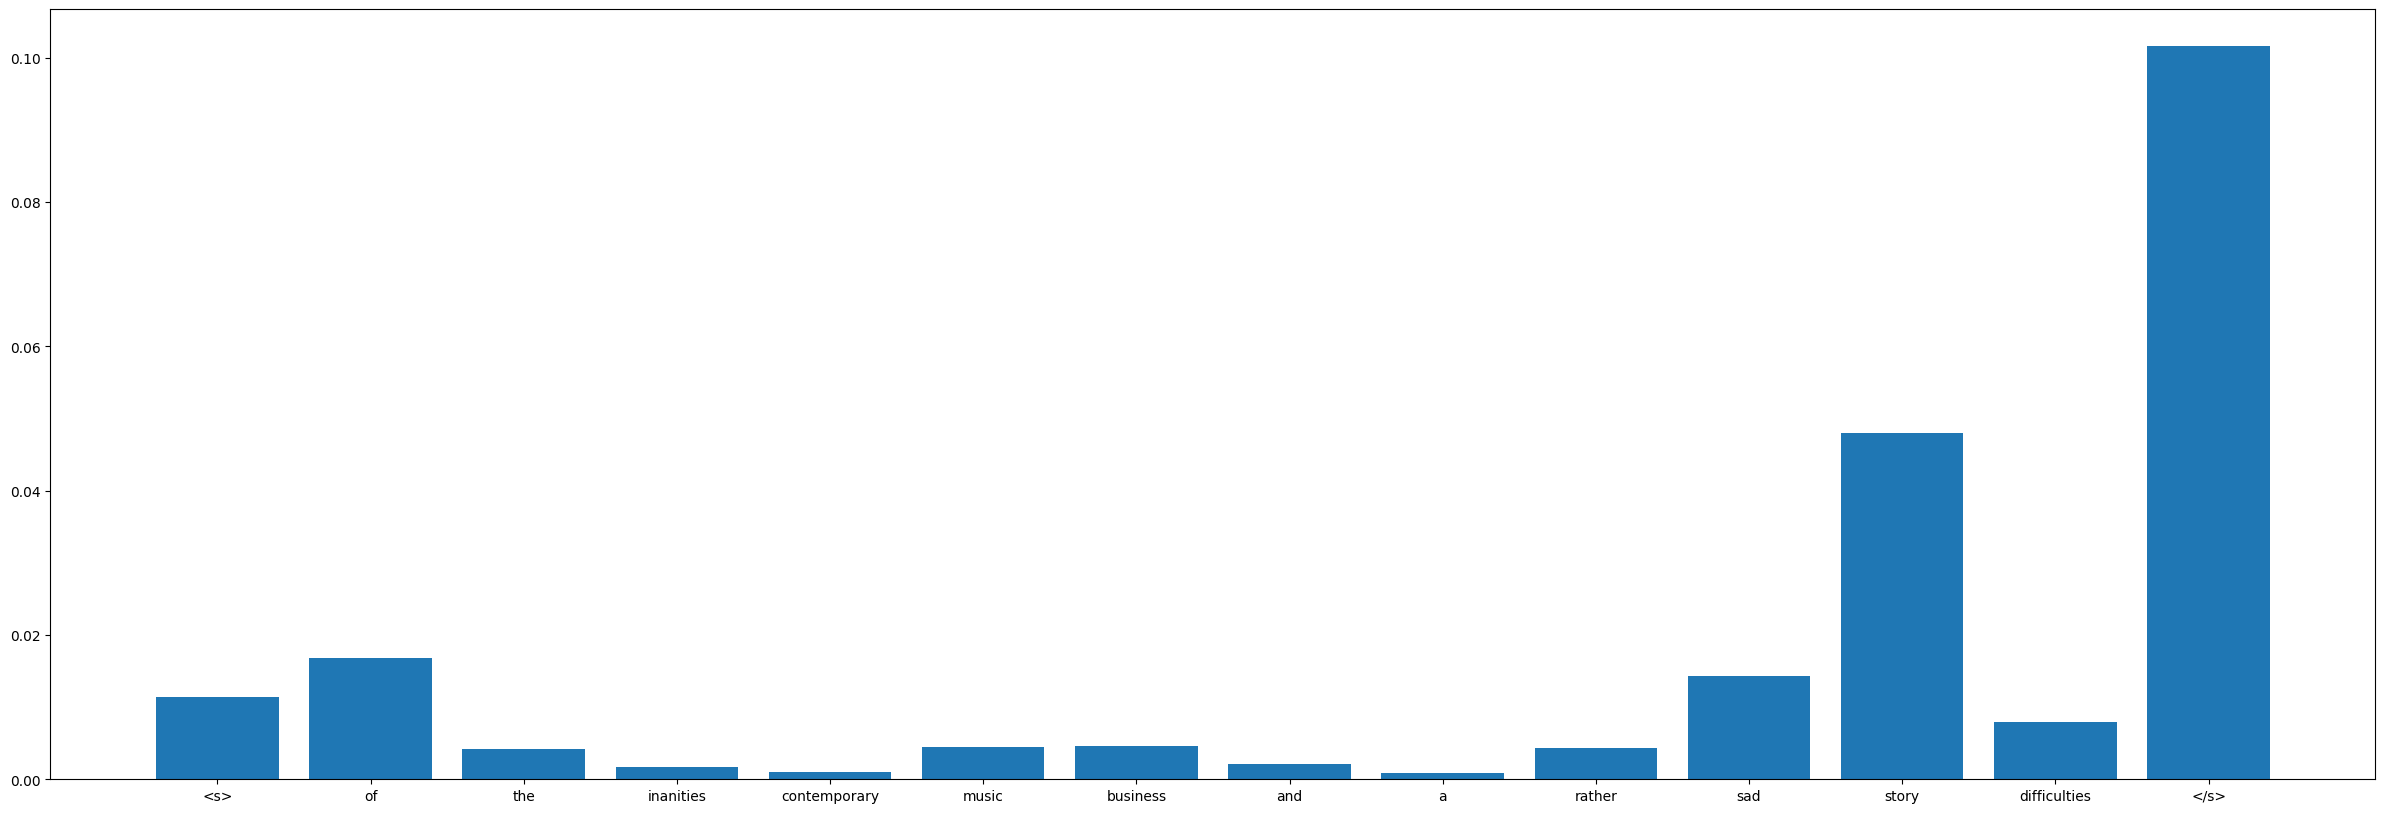

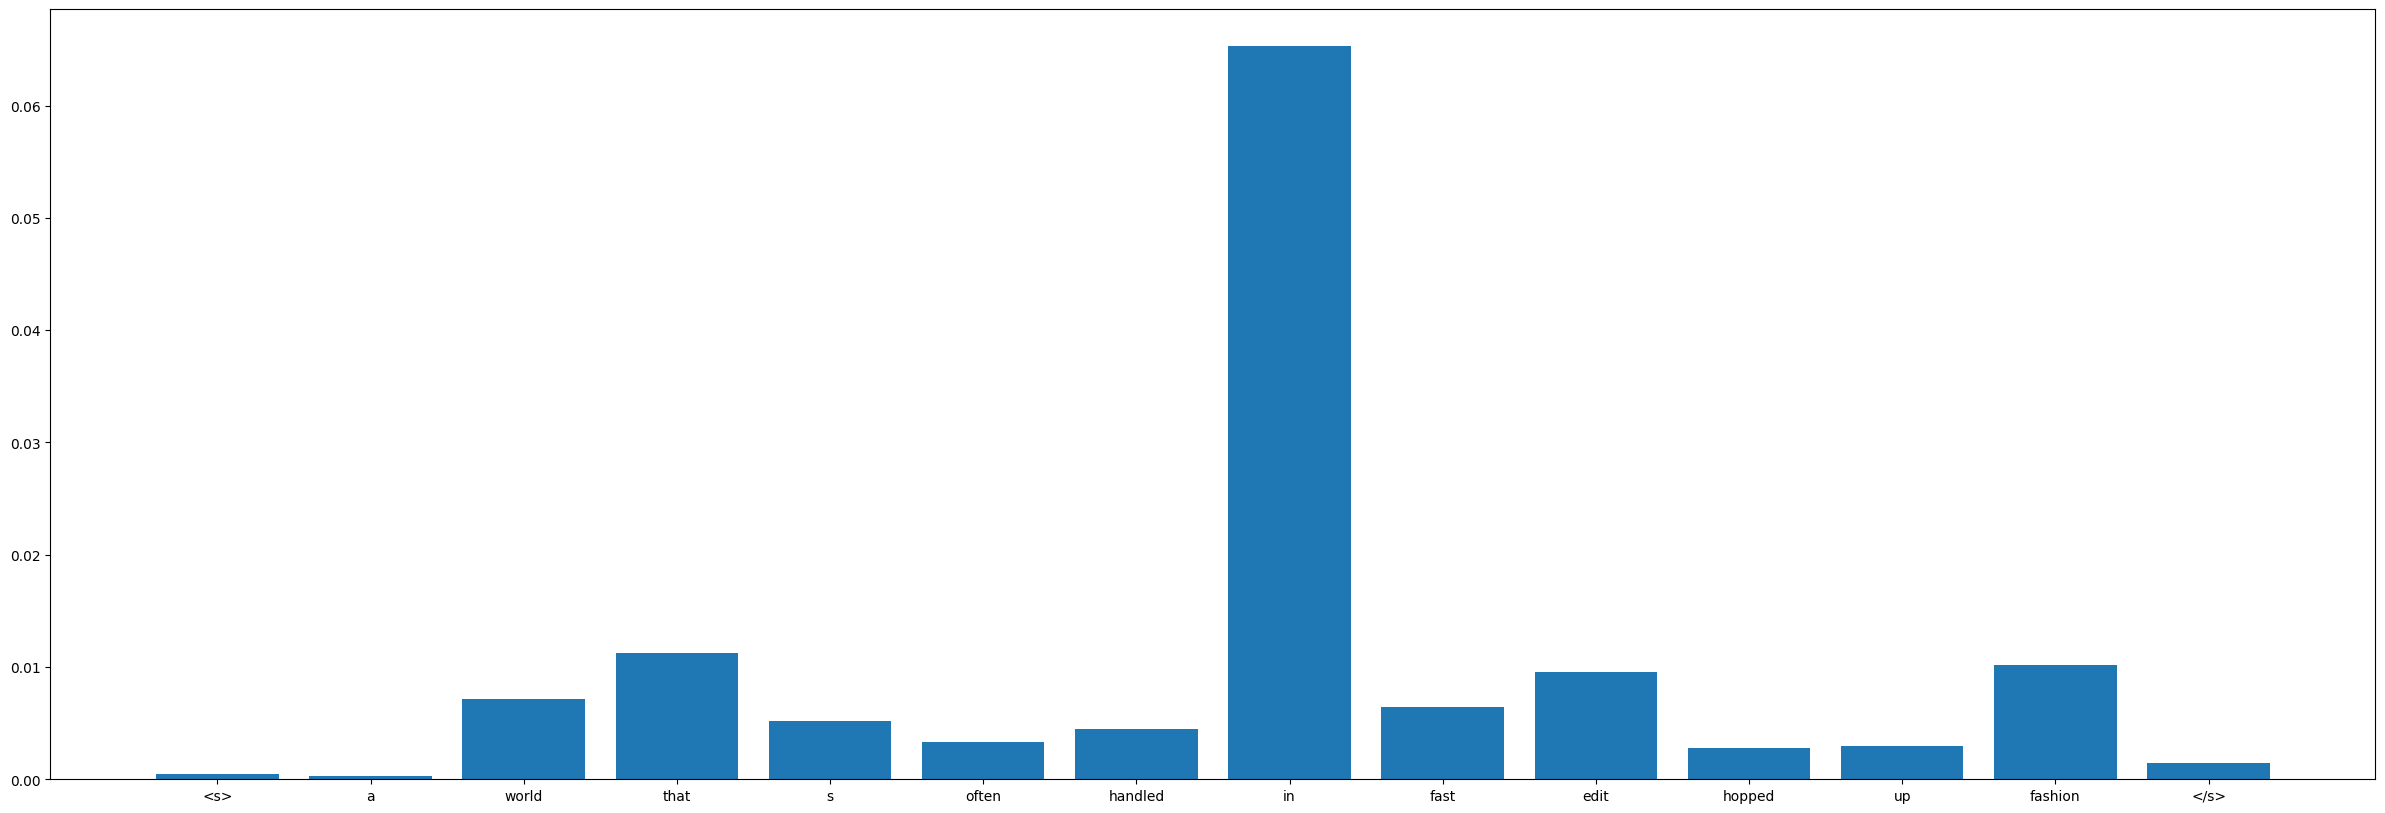

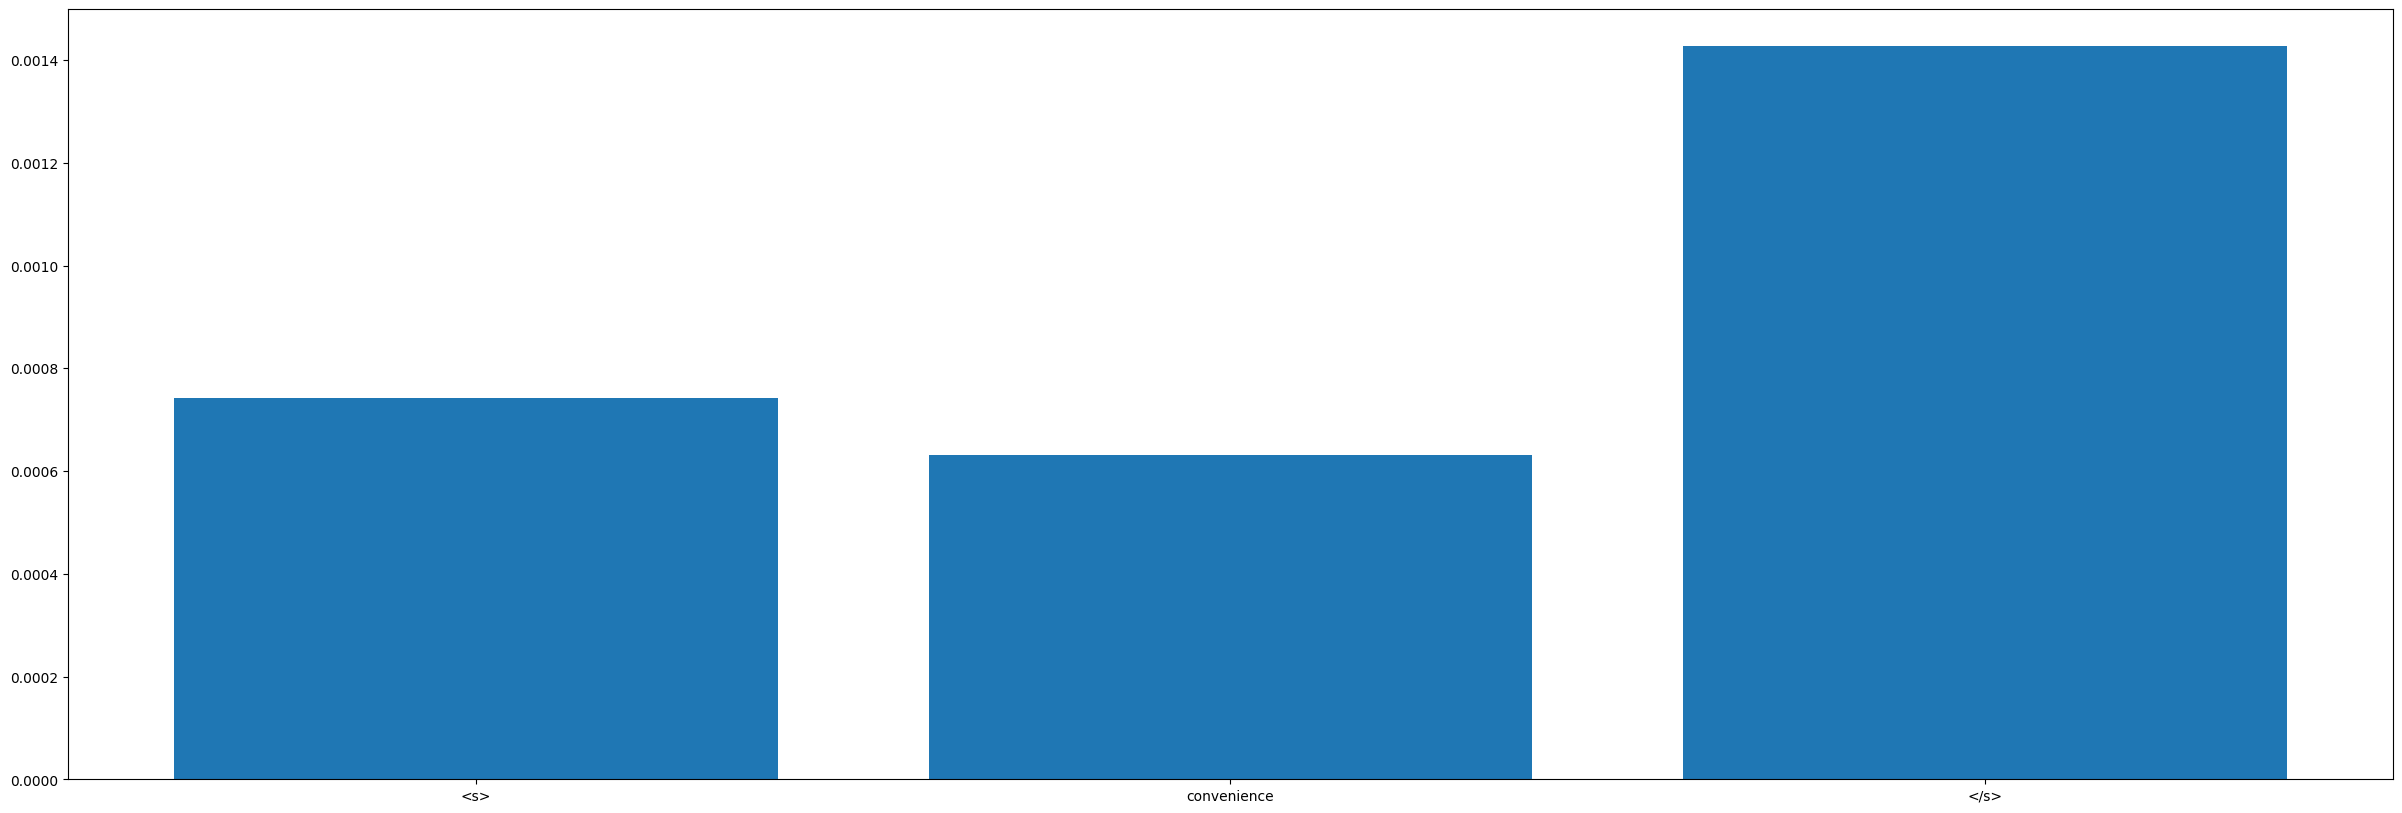

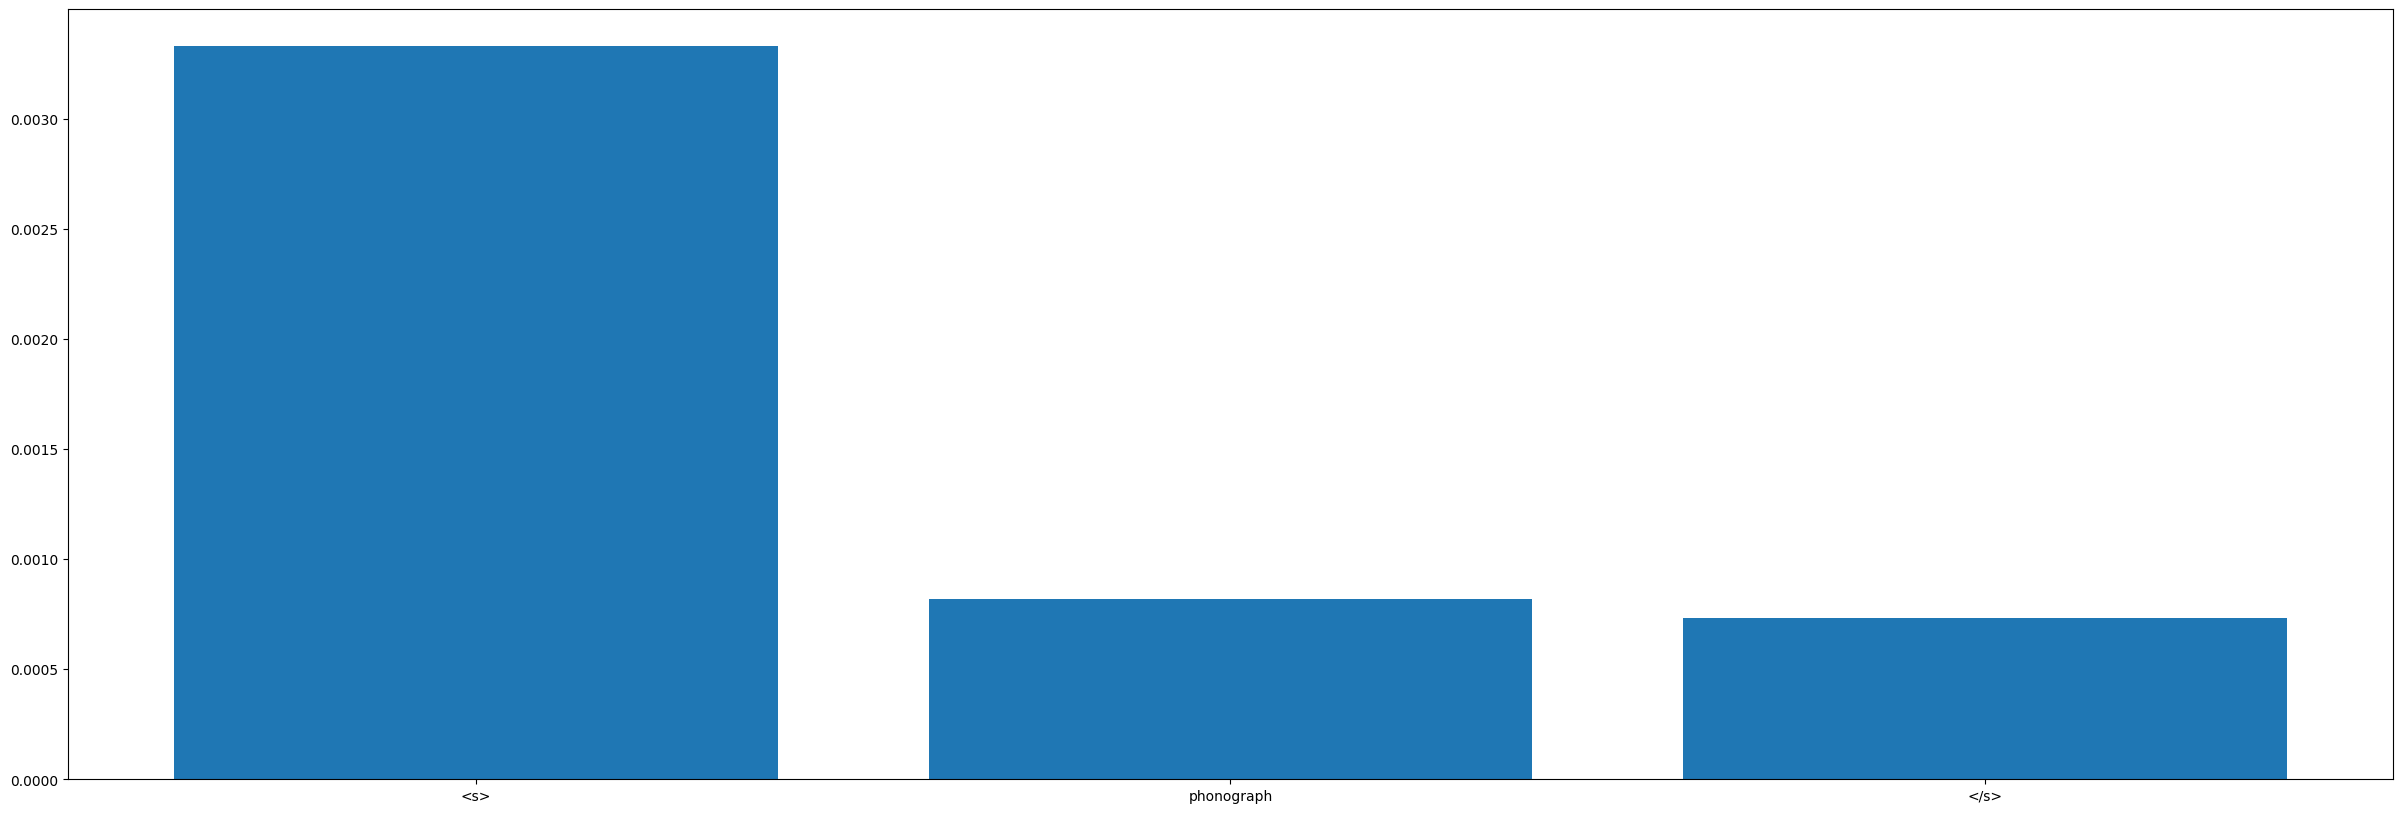

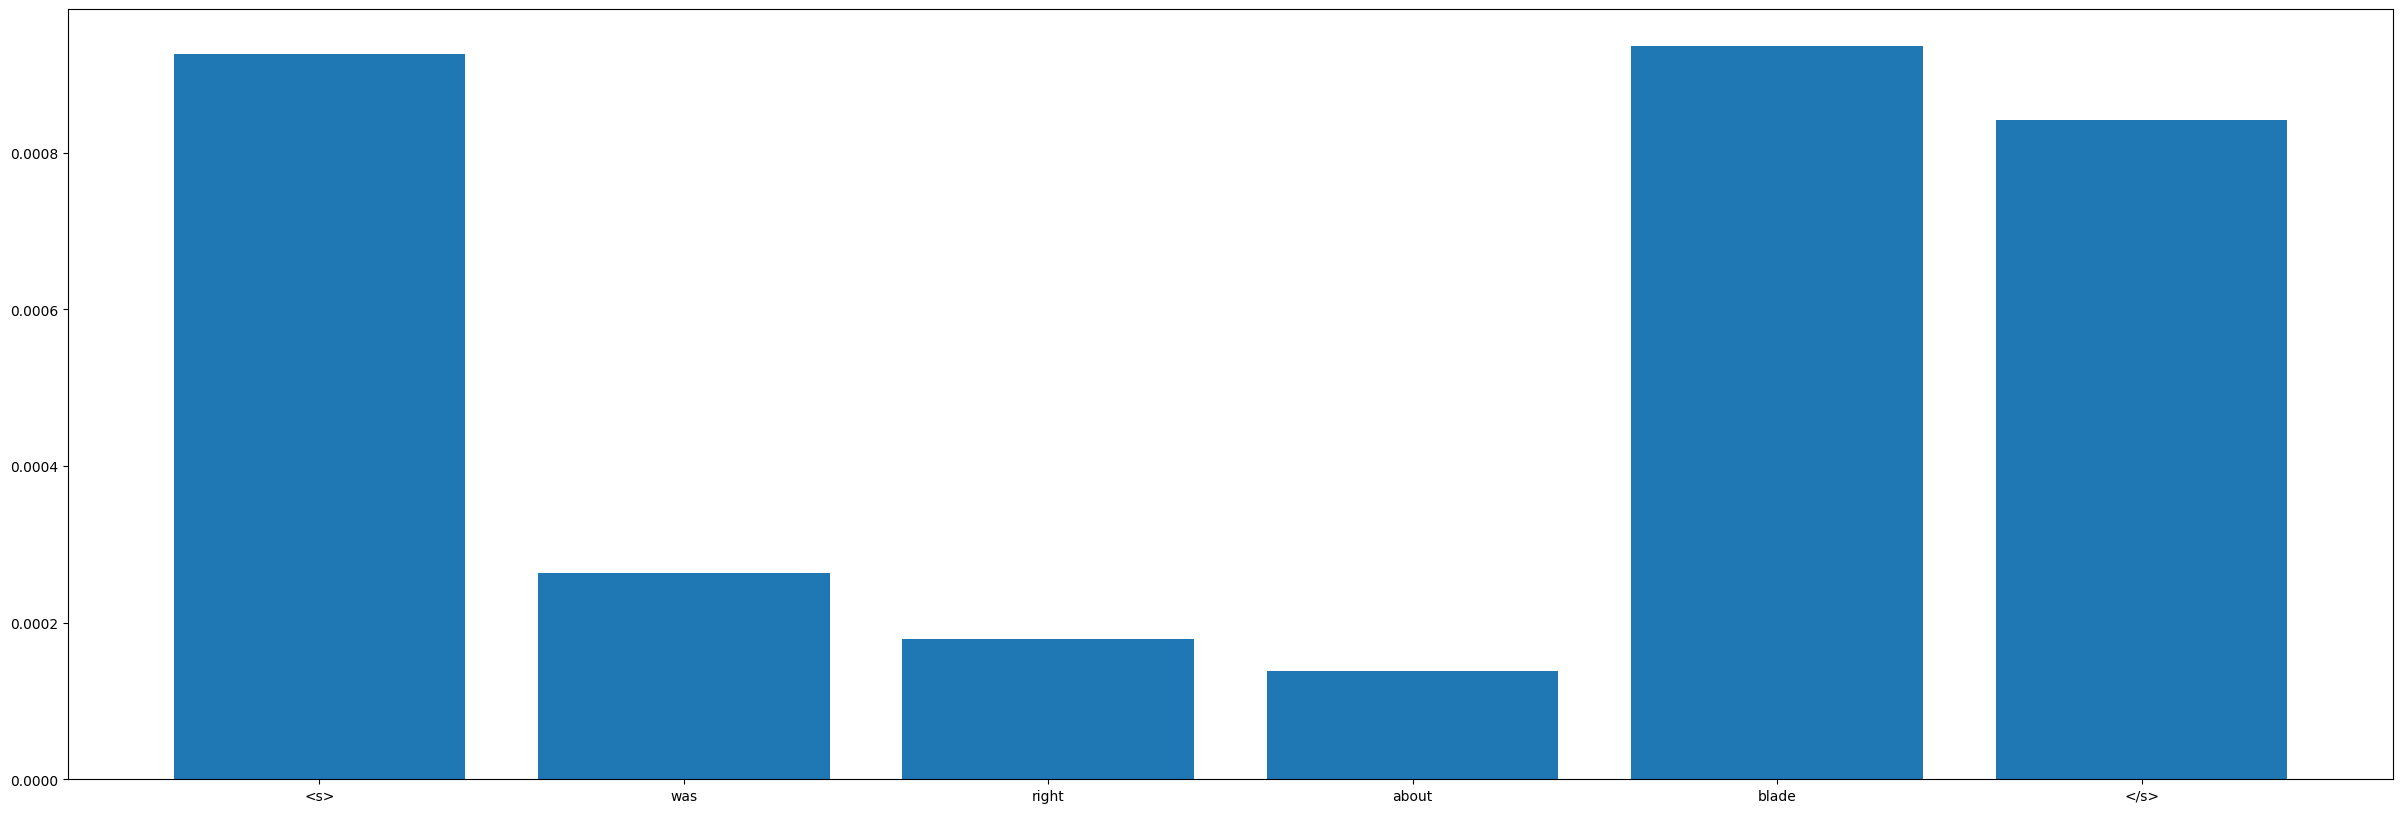

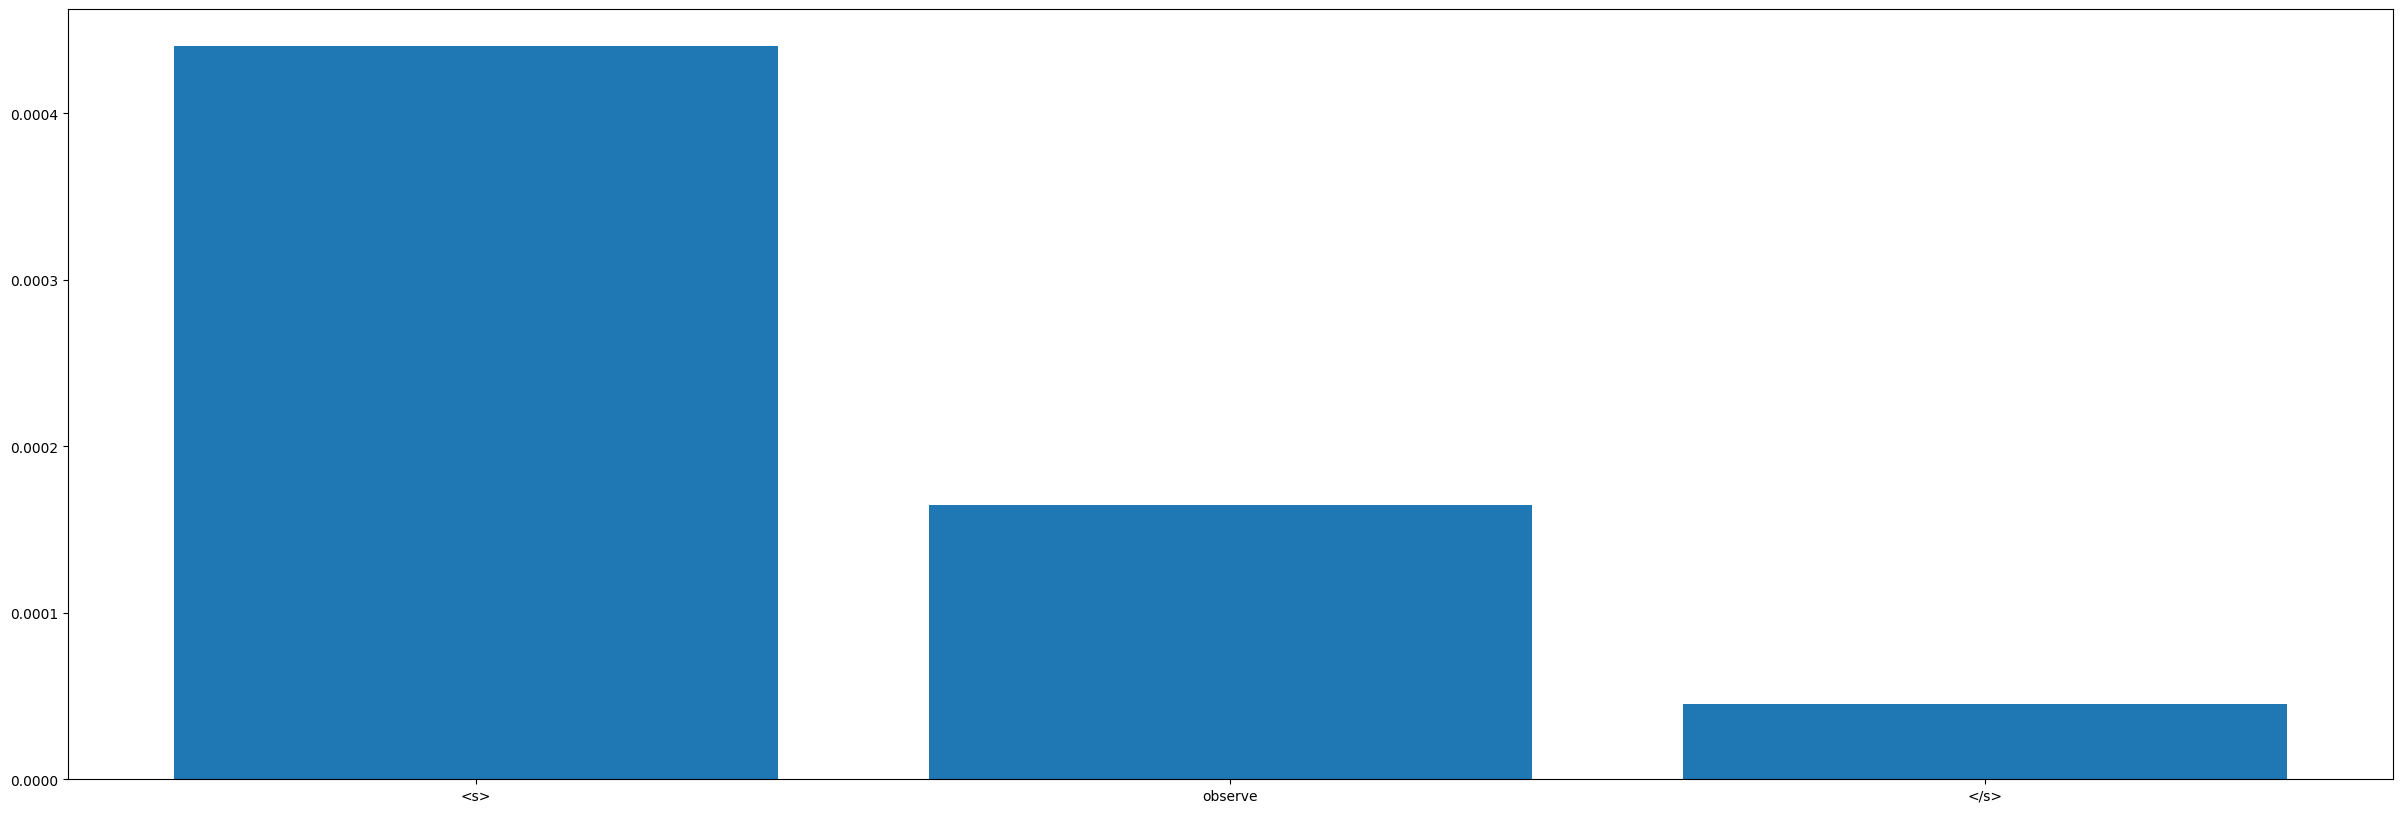

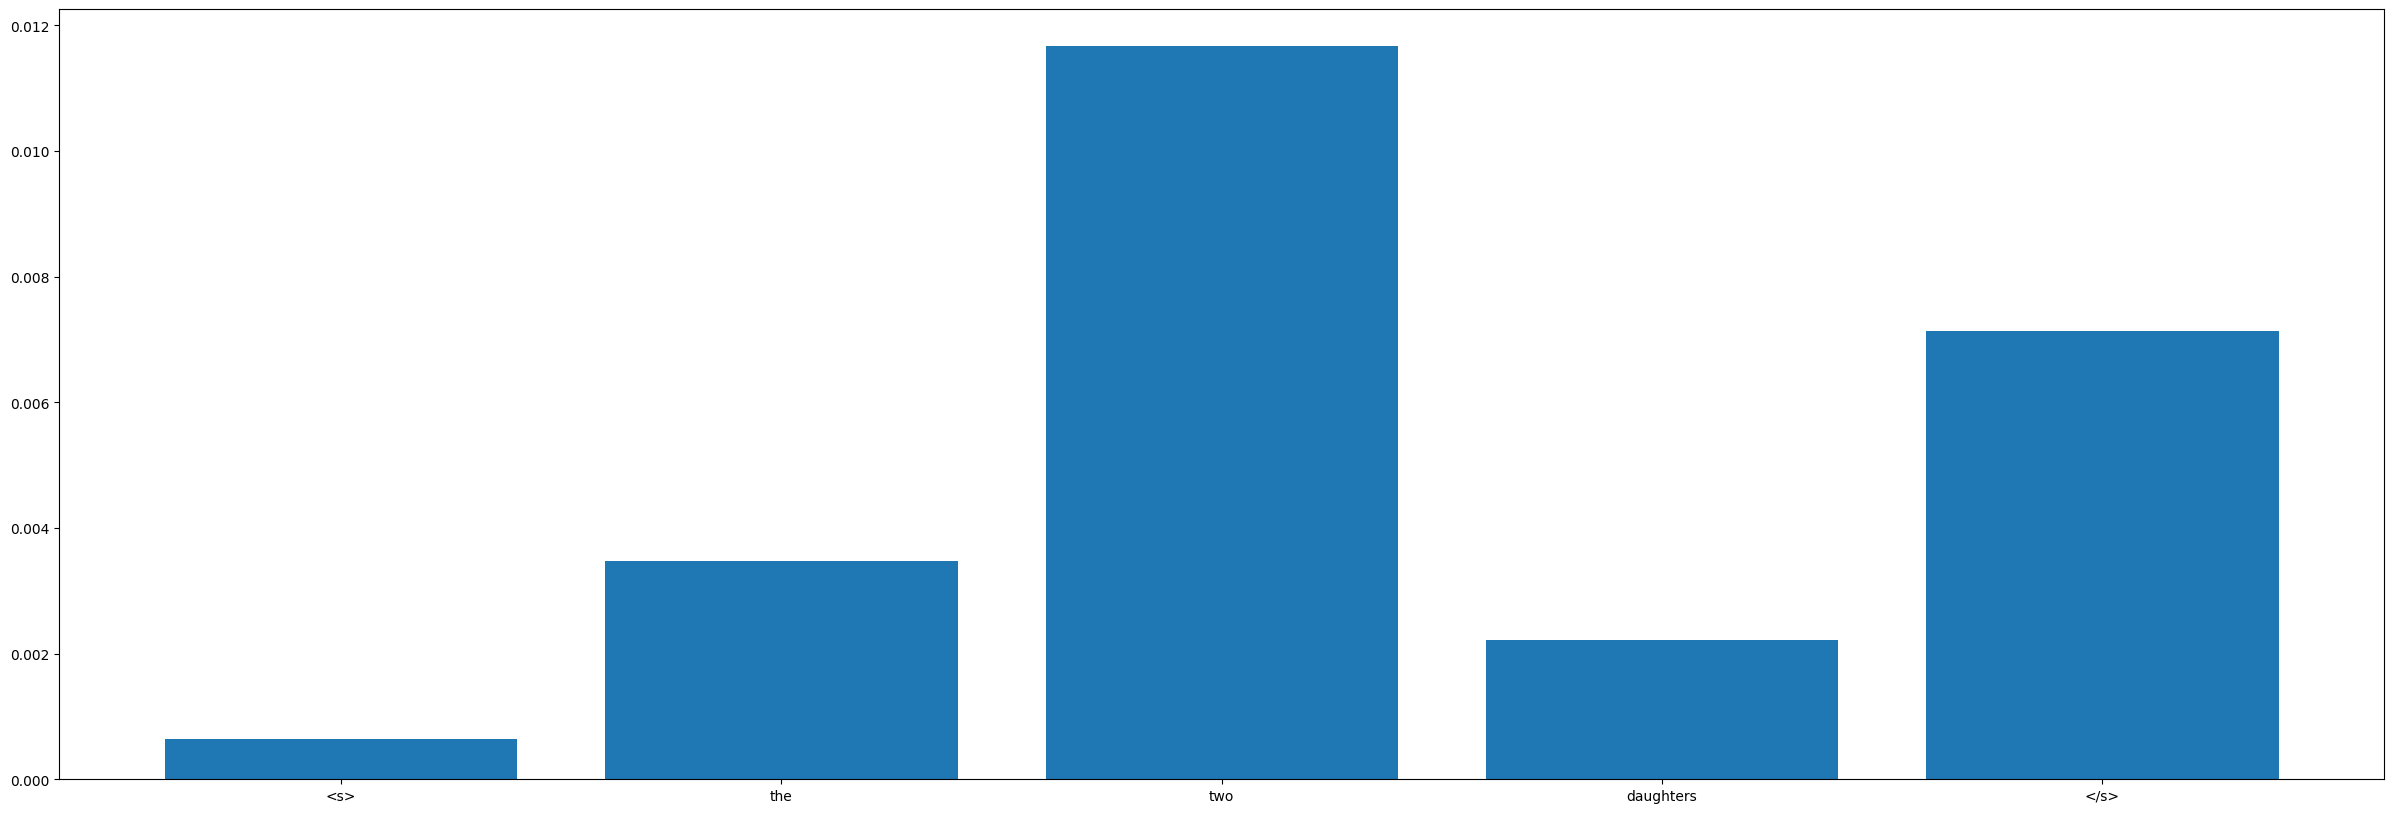

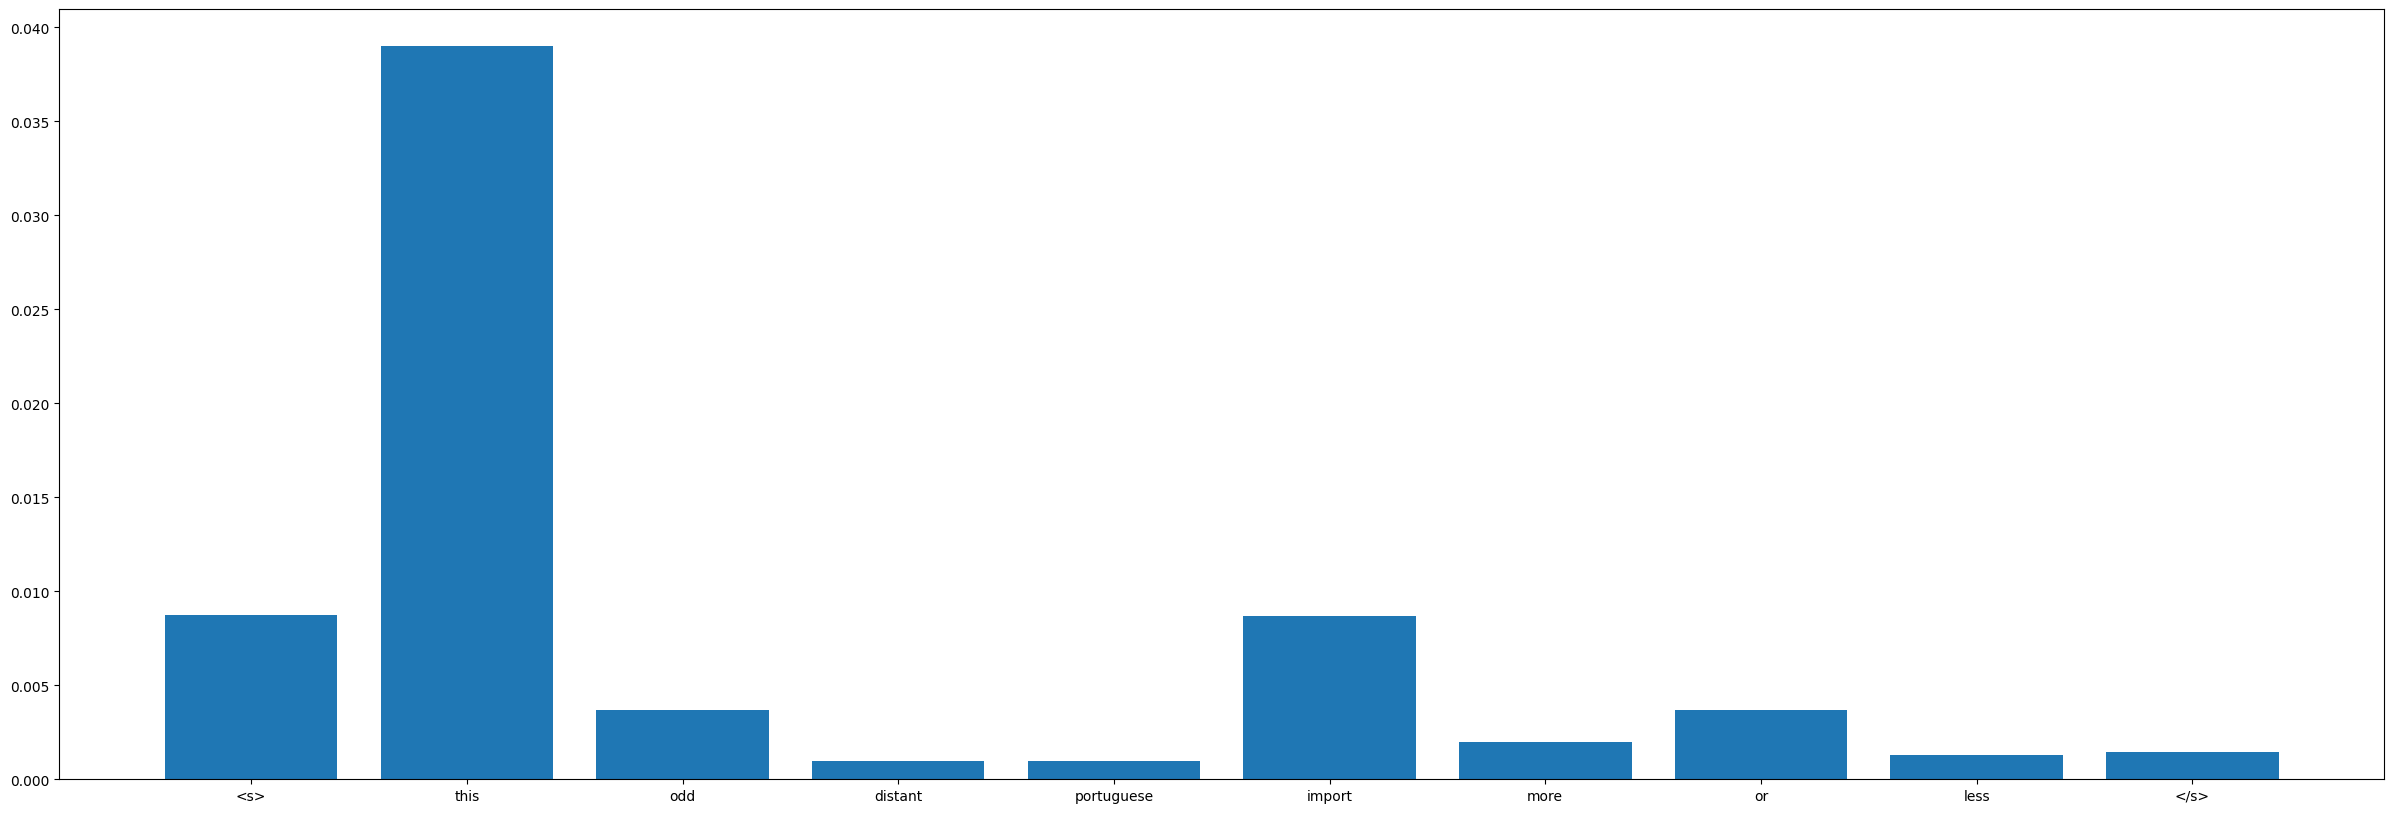

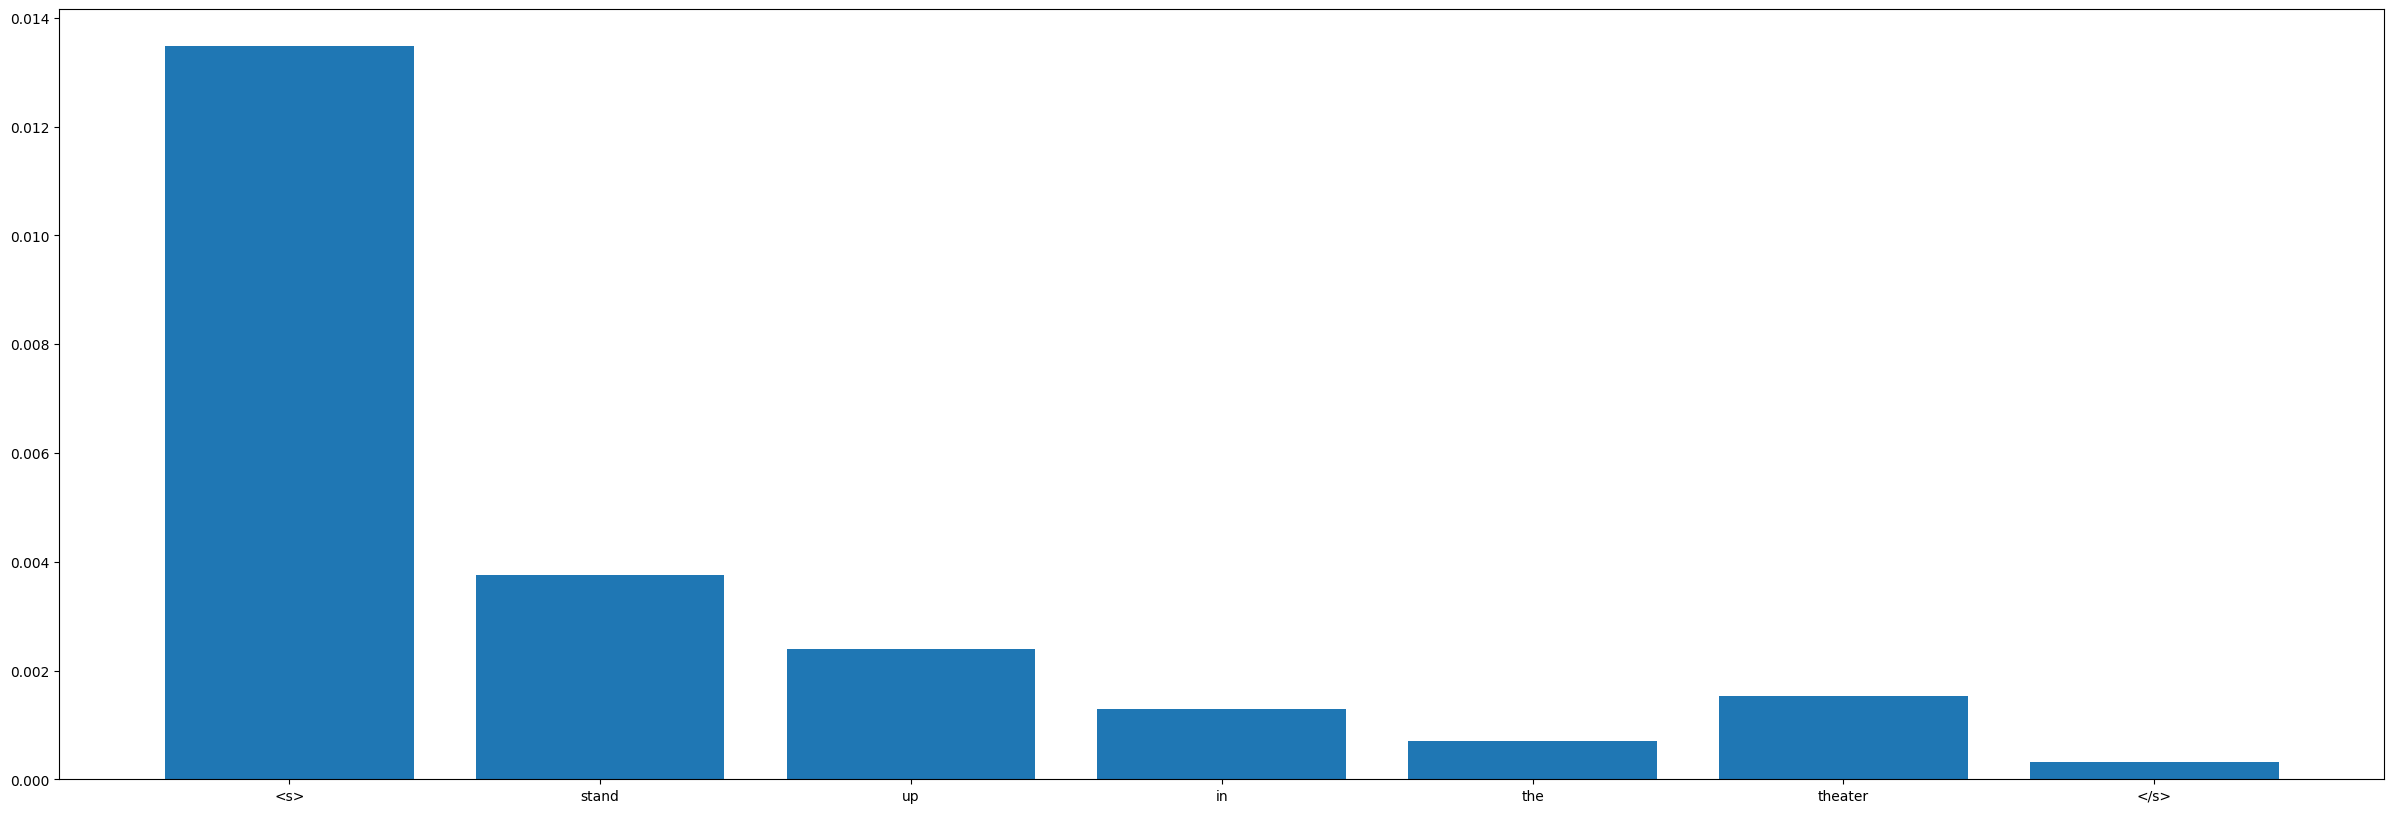

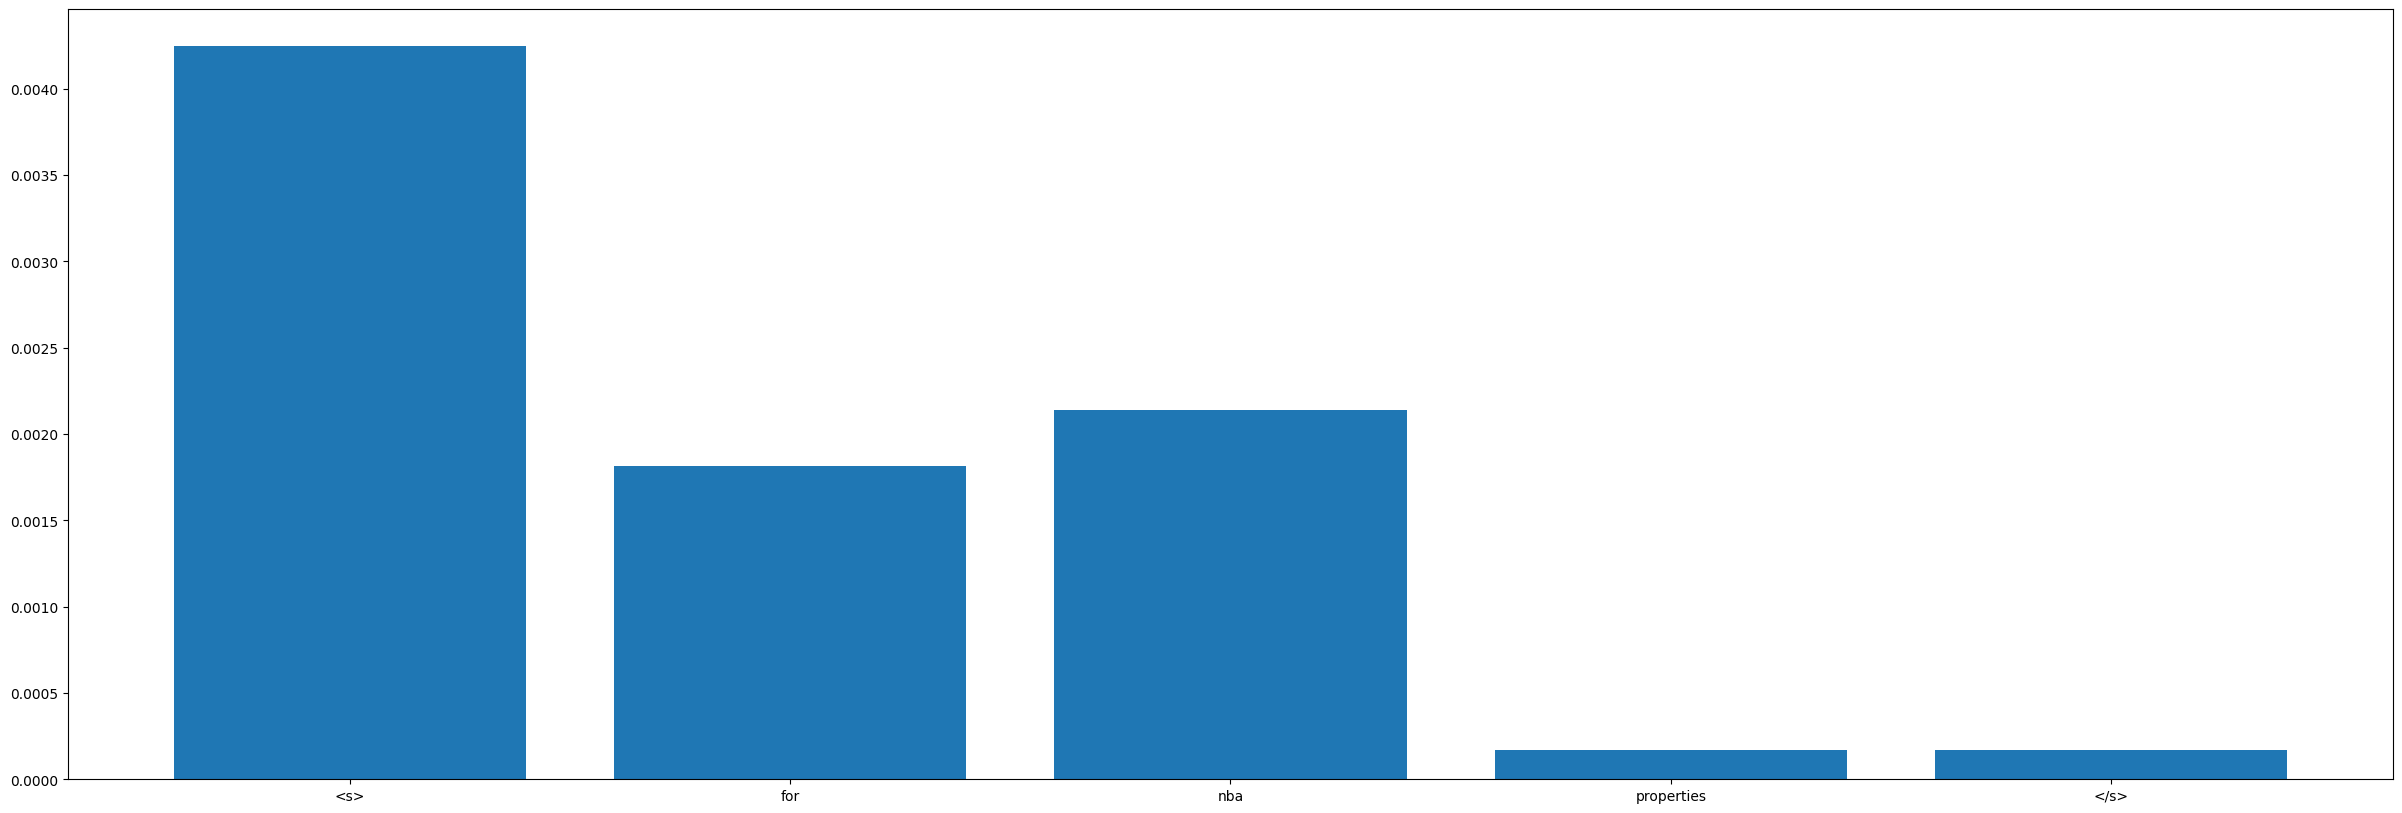

In [13]:
### TODO: 2.4 Visualize the attention weights

### YOUR CODE HERE

NUM_VISUALISATIONS = 10

for i in range(NUM_VISUALISATIONS):
    text = data_samples[train_idcs[i]]
    scores = attention_scores[i, :len(text)]
    plt.figure(figsize=(30, 10))
    plt.bar(text, scores.numpy())
    plt.show()

### END YOUR CODE